# Classify a Raster Using Threshold Values

In this tutorial, we will work with the NEON AOP L3 LiDAR ecoysystem structure (Canopy Height Model) data product. Refer to the links below for more information about NEON data products and the CHM product DP3.30015.001:

- http://data.neonscience.org/data-products/explore
- http://data.neonscience.org/data-products/DP3.30015.001

## Objectives

By the end of this tutorial, you should be able to 

1. Use `gdal` to read NEON LiDAR Raster Geotifs (eg. CHM, Slope Aspect) into a Python numpy array.
2. Create a classified array using thresholds.

A useful resource for using `gdal` in Python is the Python GDAL/OGR cookbook. 

https://pcjericks.github.io/py-gdalogr-cookbook/

First, let's import the required packages and set our plot display to be in-line:

In [1]:
import numpy as np
import gdal, copy
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Open a Geotif with GDAL

Let's look at the SERC Canopy Height Model (CHM) to start. We can open and read this in Python using the ```gdal.Open``` function:

In [2]:
chm_filename = r'C:\Users\bhass\Documents\GitHub\NEON_RSDI\RSDI_2018\Day2_LiDAR\data\NEON_D02_SERC_DP3_368000_4306000_CHM.tif'
chm_dataset = gdal.Open(chm_filename)
chm_dataset

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x000001F24A2A68D0> >

### Read information from Geotif Tags
The Geotif file format comes with associated metadata containing information about the location and coordinate system/projection. Once we have read in the dataset, we can access this information with the following commands: 

In [3]:
#Display the dataset dimensions, number of bands, driver, and geotransform 
cols = chm_dataset.RasterXSize; print('# of columns:',cols)
rows = chm_dataset.RasterYSize; print('# of rows:',rows)
print('# of bands:',chm_dataset.RasterCount)
print('driver:',chm_dataset.GetDriver().LongName)

# of columns: 1000
# of rows: 1000
# of bands: 1
driver: GeoTIFF


### ```GetProjection``` 
We can use the `gdal` ```GetProjection``` method to display information about the coordinate system and EPSG code. 

In [4]:
print('projection:',chm_dataset.GetProjection())

projection: PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32618"]]


### ```GetGeoTransform```

The geotransform contains information about the origin (upper-left corner) of the raster, the pixel size, and the rotation angle of the data. All NEON data in the latest format have zero rotation. In this example, the values correspond to: 

In [5]:
print('geotransform:',chm_dataset.GetGeoTransform())

geotransform: (368000.0, 1.0, 0.0, 4307000.0, 0.0, -1.0)


In this case, the geotransform values correspond to:

1. Left-Most X Coordinate = `367000.0`
2. W-E Pixel Resolution = `1.0`
3. Rotation (0 if Image is North-Up) = `0.0`
4. Upper Y Coordinate = `4307000.0`
5. Rotation (0 if Image is North-Up) = `0.0`
6. N-S Pixel Resolution = `-1.0` 

The negative value for the N-S Pixel resolution reflects that the origin of the image is the upper left corner. We can convert this geotransform information into a spatial extent (xMin, xMax, yMin, yMax) by combining information about the origin, number of columns & rows, and pixel size, as follows:

In [6]:
chm_mapinfo = chm_dataset.GetGeoTransform()
xMin = chm_mapinfo[0]
yMax = chm_mapinfo[3]

xMax = xMin + chm_dataset.RasterXSize/chm_mapinfo[1] #divide by pixel width 
yMin = yMax + chm_dataset.RasterYSize/chm_mapinfo[5] #divide by pixel height (note sign +/-)
chm_ext = (xMin,xMax,yMin,yMax)
print('chm raster extent:',chm_ext)

chm raster extent: (368000.0, 369000.0, 4306000.0, 4307000.0)


### `GetRasterBand`
We can read in a single raster band with `GetRasterBand` and access information about this raster band such as the No Data Value, Scale Factor, and Statitiscs as follows:

In [7]:
chm_raster = chm_dataset.GetRasterBand(1)
noDataVal = chm_raster.GetNoDataValue(); print('no data value:',noDataVal)
scaleFactor = chm_raster.GetScale(); print('scale factor:',scaleFactor)
chm_stats = chm_raster.GetStatistics(True,True)
print('SERC CHM Statistics: Minimum=%.2f, Maximum=%.2f, Mean=%.3f, StDev=%.3f' % 
      (chm_stats[0], chm_stats[1], chm_stats[2], chm_stats[3]))

no data value: -9999.0
scale factor: 1.0
SERC CHM Statistics: Minimum=0.00, Maximum=32.55, Mean=7.698, StDev=9.057


### ```ReadAsArray``` 

Finally we can convert the raster to an array using the `gdal` `ReadAsArray` method. Cast the array to a floating point value using `astype(np.float)`. Once we generate the array, we want to set No Data Values to `nan`, and apply the scale factor (for CHM this is just 1.0, so will not matter, but it's a good habit to get into): 

In [8]:
#Read Raster Band as an Array
chm_array = chm_dataset.GetRasterBand(1).ReadAsArray(0,0,cols,rows).astype(np.float)

#Assign CHM No Data Values to NaN
chm_array[chm_array==int(noDataVal)]=np.nan 

#Apply Scale Factor
chm_array=chm_array/scaleFactor
print('SERC CHM Array:\n',chm_array) #display array values

SERC CHM Array:
 [[ 16.51000023  16.82999992  16.54999924 ...,   0.           0.           0.        ]
 [ 11.81999969  14.68999958  14.40999985 ...,   0.           0.           0.        ]
 [ 12.01000023  12.81000042   3.18000007 ...,   0.           0.           0.        ]
 ..., 
 [ 27.30999947  26.87000084  26.64999962 ...,   0.           0.           0.        ]
 [ 26.71999931  27.11000061  27.11000061 ...,   0.           0.           0.        ]
 [ 26.87999916  27.05999947  27.12999916 ...,   0.           0.           0.        ]]


Let's look at the dimensions of the array we read in:

In [9]:
chm_array.shape

(1000, 1000)

We can calculate the % of pixels that are undefined (`nan`) and non-zero using `np.count_nonzero`. Typically tiles in the center of a site will have close to 0% NaN, but tiles on the edges of sites may have a large percent of `nan` values. 

In [10]:
pct_nan = np.count_nonzero(np.isnan(chm_array))/(rows*cols)
print('% NaN:',round(pct_nan*100,2))
print('% non-zero:',round(100*np.count_nonzero(chm_array)/(rows*cols),2))

% NaN: 0.0
% non-zero: 49.1


### Plot Canopy Height Data

To get a better idea of the dataset, we can use a similar function to `plot_aop_refl` that we used in the NEON AOP reflectance tutorials:

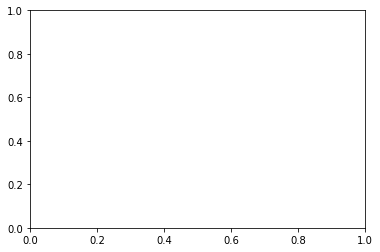

In [11]:
def plot_spatial_array(band_array,spatial_extent,colorlimit,ax=plt.gca(),title='',cmap_title='',colormap=''):
    plot = plt.imshow(band_array,extent=spatial_extent,clim=colorlimit); 
    cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
    cbar.set_label(cmap_title,rotation=90,labelpad=20);
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain'); #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90); #rotate x tick labels 90 degrees

### Plot Histogram of Data 

As we did with the reflectance tile, it is often useful to plot a histogram of the geotiff data in order to get a sense of the range and distribution of values. First we'll make a copy of the array and remove the `nan` values. 

(0, 15000)

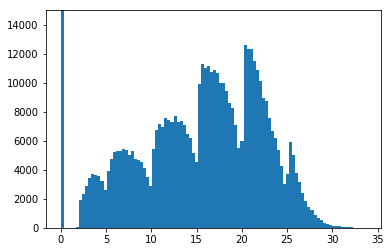

In [12]:
plt.hist(chm_array[~np.isnan(chm_array)],100);
ax = plt.gca()
ax.set_ylim([0,15000]) #adjust the y limit to zoom in on area of interest

On your own, adjust the number of bins, and range of the y-axis to get a good idea of the distribution of the canopy height values. We can see that most of the values are zero. In SERC, many of the zero CHM values correspond to bodies of water as well as regions of land without trees. Let's look at a  histogram and plot the data without zero values: 

Note that it appears that the trees don't have a smooth or normal distribution, but instead appear blocked off in chunks. This is an artifact of the Canopy Height Model algorithm, which bins the trees into 5m increments (this is done to avoid another artifact of "pits" (Khosravipour et al., 2014). 

From the histogram we can see that the majority of the trees are < 30m. We can re-plot the CHM array, this time adjusting the color bar limits to better visualize the variation in canopy height. We will plot the non-zero array so that CHM=0 appears white. 

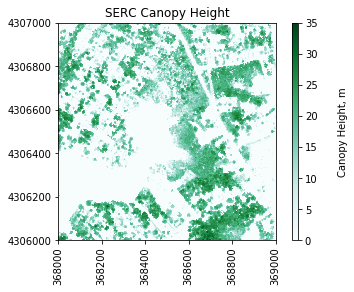

In [13]:
plot_spatial_array(chm_array,
                   chm_ext,
                   (0,35),
                   title='SERC Canopy Height',
                   cmap_title='Canopy Height, m',
                   colormap='BuGn')

## Threshold Based Raster Classification
Next, we will create a classified raster object. To do this, we will use the se the numpy.where function to create a new raster based off boolean classifications. Let's classify the canopy height into five groups:
- Class 1: **CHM = 0 m** 
- Class 2: **0m < CHM <= 10m**
- Class 3: **10m < CHM <= 20m**
- Class 4: **20m < CHM <= 30m**
- Class 5: **CHM > 30m**

We can use `np.where` to find the indices where a boolean criteria is met. 

In [14]:
chm_reclass = chm_array.copy()
chm_reclass[np.where(chm_array==0)] = 1 # CHM = 0 : Class 1
chm_reclass[np.where((chm_array>0) & (chm_array<=10))] = 2 # 0m < CHM <= 10m - Class 2
chm_reclass[np.where((chm_array>10) & (chm_array<=20))] = 3 # 10m < CHM <= 20m - Class 3
chm_reclass[np.where((chm_array>20) & (chm_array<=30))] = 4 # 20m < CHM <= 30m - Class 4
chm_reclass[np.where(chm_array>30)] = 5 # CHM > 30m - Class 5

We can define our own colormap to plot these discrete classifications, and create a custom legend to label the classes:

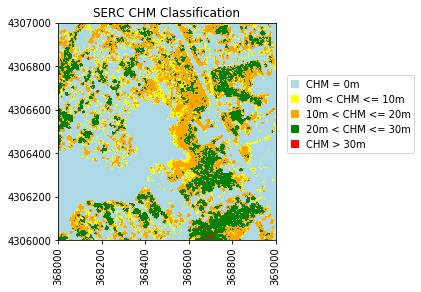

In [15]:
import matplotlib.colors as colors
plt.figure(); 
cmapCHM = colors.ListedColormap(['lightblue','yellow','orange','green','red'])
plt.imshow(chm_reclass,extent=chm_ext,cmap=cmapCHM)
plt.title('SERC CHM Classification')
ax=plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

# Create custom legend to label the four canopy height classes:
import matplotlib.patches as mpatches
class1_box = mpatches.Patch(color='lightblue', label='CHM = 0m')
class2_box = mpatches.Patch(color='yellow', label='0m < CHM <= 10m')
class3_box = mpatches.Patch(color='orange', label='10m < CHM <= 20m')
class4_box = mpatches.Patch(color='green', label='20m < CHM <= 30m')
class5_box = mpatches.Patch(color='red', label='CHM > 30m')

ax.legend(handles=[class1_box,class2_box,class3_box,class4_box,class5_box],
          handlelength=0.7,bbox_to_anchor=(1.05, 0.4),loc='lower left',borderaxespad=0.)

## Challenge 1: Document Your Workflow 
1. Look at the code that you created for this lesson. Now imagine yourself months in the future. Document your script so that your methods and process is clear and reproducible for yourself or others to follow when you come back to this work at a later date. 
2. In documenting your script, synthesize the outputs. Do they tell you anything about the vegetation structure at the field site? 

## Challenge 2: Try Another Classification
Create the following threshold classified outputs:
1. A raster where NDVI values are classified into the following categories:
    * Low greenness: NDVI < 0.3
    * Medium greenness: 0.3 < NDVI < 0.6
    * High greenness: NDVI > 0.6
2. A raster where aspect is classified into North and South facing slopes: 
    * North: 0-45 & 315-360 degrees 
    * South: 135-225 degrees
    
<p>
<img src="files/NSEW_Classification.jpg" style="width: 250px;"/>
</p>

Be sure to document your workflow as you go using Jupyter Markdown cells. When you are finished, export your outputs to HTML by selecting File > Download As > HTML (.html). Save the file as LastName_Tues_classifyThreshold.html. Add this to the Tuesday directory in your DI18-NEON-participants Git directory and push them to your fork in GitHub. Merge with the central repository using a pull request. 

## References 

Khosravipour, Anahita & Skidmore, Andrew & Isenburg, Martin & Wang, Tiejun & Hussin, Yousif. (2014). Generating Pit-free Canopy Height Models from Airborne Lidar. Photogrammetric Engineering & Remote Sensing. 80. 863-872. 10.14358/PERS.80.9.863. 

https://www.researchgate.net/publication/273663100_Generating_Pit-free_Canopy_Height_Models_from_Airborne_Lidar